## Imports

In [1]:
import pandas as pd
from collections import Counter
import seaborn as sns
import numpy 
import scipy

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,f1_score
from sklearn.linear_model import LogisticRegression
from sys import getsizeof

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

from sklearn.model_selection import train_test_split
from rfpimp import *

from functools import reduce

scorer = make_scorer(f1_score, needs_proba=False,
                     greater_is_better=True,average='micro')

## Data import

In [2]:
df = pd.read_csv('../input/train_values.csv')
train_target = pd.read_csv('../input/train_labels.csv')

print(Counter(train_target.damage_grade))

y = train_target.damage_grade

Counter({2: 148259, 3: 87218, 1: 25124})


## Utils

In [3]:
def give_sub_file(preds, ids, path='../output/preds.csv'):
    preds = pd.DataFrame(preds,columns=['damage_grade'])
    preds['building_id'] = ids
    preds = preds[['building_id', 'damage_grade']]
    print(preds.columns)
    print(preds.shape)
    preds.to_csv(path, index=False)


def corr_thres(df, threshold=0.1):
    '''df is a pandas dataframe'''
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    upper.reset_index(inplace=True)
    upper = upper.melt(id_vars=['index'],var_name='col2',value_name='corr')
    upper.columns = ['col1','col2','correlation']
    upper = upper.dropna()
    upper = upper.loc[upper.correlation>threshold]

    return upper.reset_index(drop=True)

def gini(y):
#     assert y.ndim == 1
    _, fracs = np.unique(y, return_counts=True)
    fracs = fracs/len(y)
    return 1 - np.linalg.norm(fracs, ord=2)**2

def combine_cols(l):
    return reduce(lambda x,y:x+y, l)

In [ ]:
# preds = estimator.predict(X_test)
# give_sub_file(preds, X_test.building_id.tolist())

## Class distribution

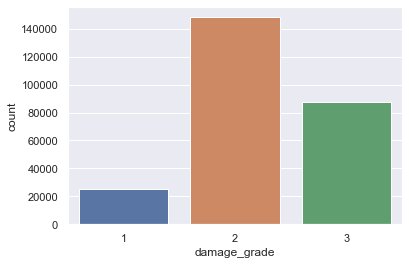

In [11]:
sns.set(style="darkgrid")

ax = sns.countplot(x="damage_grade", data=train_target)

In [15]:
# Metric to be used
# F1 score with argument micro has to be used

In [16]:
from sklearn.metrics import f1_score

f1_score(y_true= , y_pred = average='micro')

## Base line model always predict mode ( class = 2 ) 

In [18]:
# lets see our f1 score (micro) when we always predict the 2nd class

In [19]:
y_true =  train_target.damage_grade
y_pred = [2]*len(y_true)

In [20]:
f1_score(y_true, y_pred, average='micro')

0.5689118614280068

Number 1 on leaderboard score = 0.7544

In [6]:
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


Feature Description

https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/

### Does buliding ID give us something

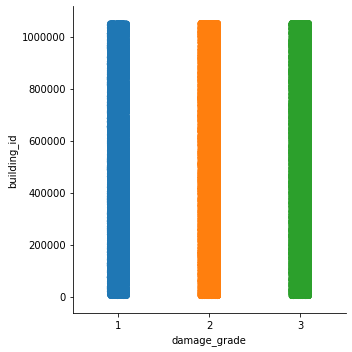

In [16]:
sns.catplot(x="damage_grade", y="building_id", data=train_target);

## Data Processing

In [4]:
def create_X(df):
    X = df.copy()
    
#     X['disc'] = X['ground_floor_type'].astype(str) + X['other_floor_type'].astype(str)  # new feature
    
    cat_cols = X.columns[X.dtypes == 'object']
    num_cols = [i for i in X.columns if i not in cat_cols]
    
    x1 = X[cat_cols].apply(LabelEncoder().fit_transform)
    X = pd.concat([X[num_cols], x1], axis=1)
    
    return X

def _new_ids(l1, l2):
    '''l1 and l2 are np.arrays
    l1 = train array
    l2 = test array
    '''
    
    if not isinstance(l1, np.ndarray):
        l1 = np.array(l1)
    if not isinstance(l2, np.ndarray):
        l2 = np.array(l2)
    
    mode = scipy.stats.mode(l1)[0][0]  # mode value of train
    
    bool_arr = np.array([i in l1 for i in l2])
    out = l2.copy()
    out[~bool_arr] = mode
    
    
    return out

def replace_new_ids(train_df, test_df, cols):
    '''
    train_df = train_df
    test_df = test_df
    cols = list of columns which have new ids not in train_df
    
    This function will replace any new values in the cols of 
    test_df with the mode of trains_df
    '''
    for column in cols:
        test_df.loc[:,column] = _new_ids(train_df.loc[:,column], test_df.loc[:,column])
    return train_df, test_df
    
    
def geo23_in_geo1(X_train, X_test):
    ''' Requirement: No new geo_level_2 ids in X_test'''
    
    dic_1_2 = dict(X_train.groupby('geo_level_1_id', as_index=False)['geo_level_2_id'].nunique())
    dic_1_3 = dict(X_train.groupby('geo_level_1_id', as_index=False)['geo_level_3_id'].nunique())
    
    for frame in [X_train, X_test]:
        frame['count12'] = frame.loc[:, 'geo_level_1_id'].apply(lambda x: dic_1_2[x])
        frame['count13'] = frame.loc[:, 'geo_level_1_id'].apply(lambda x: dic_1_3[x])
    
    return X_train, X_test
    



def new_rows(l1, l2):
    s = set(l2) - set(l1)
    return len([i for i in l2 if i in s])

class FreqEncode:
    def __init__(self):
        self.freq_dict = {}
    
    def create_dict(self,train_col):
        return dict(train_col.value_counts())
    
    def fit(self, X_train, cols):
        '''
        X_train = train_df
        cols for which we need to encode frequency
        '''
        self.cols = cols
        for i in cols:
            value = self.create_dict(X_train[i])
            self.freq_dict[i] = value
    
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            X_test[i.strip()+'_fq'] = X_test[i].apply(lambda x: self.freq_dict[i][x])
        return X_test
    

class TarEncode:
    def __init__(self, func):
        self.tar_dict = {}
        self.func = func
        
    def create_dict(self, train_col, y):
        col1 = train_col.values
        df = pd.DataFrame(zip(col1, y), columns=['c1','c2'])
        df = df.groupby('c1',as_index=False).agg({'c2':self.func})
        df.columns = ['c1','c2']
        
        d = dict((i,j) for i,j in zip(df['c1'], df['c2']))
        return d
    
    def fit(self, X_train, y, cols):
        '''
        X_train = pandas dataframe 
        y = target variables np.array
        cols = list of columns for which we need to target encode
        '''
        self.cols = cols
        for i in cols:
            value = self.create_dict(X_train[i], y)
            self.tar_dict[i] = value
    
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            X_test[i.strip()+'_tq'] = X_test[i].apply(lambda x: self.tar_dict[i][x])
        return X_test
    

class FeatEncode:
    def __init__(self, func, name='_featenc'):
        '''
        Encoding the categorical feature with continuous feature mean
        both are passed in fit function
        '''
        self.tar_dict = {}
        self.func = func
        self.name = name
        
    def create_dict(self, train_col, y):
        col1 = train_col.values
        df = pd.DataFrame(zip(col1, y), columns=['c1','c2'])
        df = df.groupby('c1',as_index=False).agg({'c2':self.func})
        df.columns = ['c1','c2']
        
        d = dict((i,j) for i,j in zip(df['c1'], df['c2']))
        return d
    
    def fit(self, X_train, y, cols):
        '''
        X_train = pandas dataframe 
        y = target variables np.array
        cols = list of columns for which we need to target encode
        '''
        self.cols = cols
        for i in cols:
            value = self.create_dict(X_train[i], y)
            self.tar_dict[i] = value
    
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            X_test[i.strip()+ self.name] = X_test[i].apply(lambda x: self.tar_dict[i][x])
        return X_test
    

class TarEncodeMoreInfo:
    def __init__(self):
        self.df_dict = {}
    
    def fit(self, X_train, y, cols):
        '''
        X_train = pandas dataframe 
        y = target variables np.array
        cols = list of columns for which we need to target encode
        '''
        self.cols = cols
        df = X_train[cols]
        uniq_y = np.unique(y)
        tars = []
        for i in uniq_y:
            name = 'tar_' + str(i)
            tars.append(name)
            df[name] = (y==i).astype(int)
        
        for col in self.cols:
            sel = [col]+tars
            sel = df[sel]
            sel.columns = [col]+[f"{col}_{t}" for t in tars]
            vals = sel.columns[1:]
            self.df_dict[col] = sel.groupby(col, as_index=False)[vals].mean()
        
        
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            right = self.df_dict[i]
            X_test = pd.merge(X_test, right, left_on=i, right_on=i, how='left')
            
        return X_test
    

Can we use height_percentage feature to know if a geo_is urban or rural
Urban places should have taller building

In [5]:
def create_bin_features(X):
    vals = X.nunique()
    vals = vals[vals==2].index.tolist()
    X['zero_binvs'] = (X[vals].values==0).sum(1)
    X['one_binvs'] = (X[vals].values==1).sum(1)
    X['gini_binvs'] = [gini(i) for i in X[vals].values]
    return X
    
    

In [ ]:
X.shape

In [7]:
# X = create_bin_features(X)

In [8]:
# X, _ = geo23_in_geo1(X,X)


In [14]:
# X['geo_comb'] = X[geo_features].astype(str).apply(combine_cols, axis=1)

In [15]:
# geo_features = geo_features + ['geo_comb']

In [9]:
X = create_X(df)
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

fe = FreqEncode()
fe.fit(X,geo_features)
X = fe.transform(X)


tar_enc = TarEncode(func=np.median)
tar_enc.fit(X, y.values, geo_features)
X = tar_enc.transform(X)


In [21]:
# true_test = pd.read_csv('../input/test_values.csv')

# true_test = create_X(true_test)
# true_test['geo_comb'] = true_test[['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']].astype(str).apply(combine_cols, axis=1)

# X, true_test = replace_new_ids(X, true_test, geo_features)

# true_test = fe.transform(true_test)
# true_test = tar_enc.transform(true_test)

In [26]:
# true_test.to_feather('../output/test_with_triple_feature.feather')

In [22]:
true_test = pd.read_feather('../output/test_with_triple_feature.feather')

(86868, 48)

In [586]:
# tarencmain = TarEncodeMoreInfo()
# tarencmain.fit(X, y.values, geo_features)
# X = tarencmain.transform(X)

## Random Forest

### only freq encoding

In [571]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=1, n_jobs=-1)
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.72924437, 0.73082148, 0.72946526])

### RF with freq, tar enc and more info tar encoding

In [555]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75315421, 0.75308514, 0.75289242])

In [556]:
model.fit(X,y)
imp = importances(model,X,y)

In [557]:
top20 = imp.iloc[:20].index.tolist()

In [558]:
cross_val_score(estimator=model,X = X[top20], y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74501543, 0.74501543, 0.74478789])

### RF with freq and tar encoding

In [58]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75358014, 0.7542248 , 0.75415875])

In [21]:
np.array([0.75358014, 0.7542248 , 0.75415875]).mean()

0.7539878966666667

In [169]:
model = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75574435, 0.75642354, 0.75555172])

In [24]:
X.shape, true_test.shape

((260601, 45), (86868, 45))

In [43]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75592854, 0.75600912, 0.75597767])

In [12]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75291246, 0.75399457, 0.75445807])

In [25]:
model.fit(X,y)
preds = model.predict(true_test)
give_sub_file(preds, true_test.building_id.tolist(), path='../output/tar_freq.csv')

Index(['building_id', 'damage_grade'], dtype='object')
(86868, 2)


### remove id columns

In [100]:
# this improves f1 score 

In [95]:
cols = X.columns.tolist()
cols.remove('building_id') ## removing this has increased the accuracy

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)

In [85]:
corr_thres(X[cols], 0.7)

,col1,col2,correlation
0,count_floors_pre_eq,height_percentage,0.772734
1,has_secondary_use,has_secondary_use_agriculture,0.739059
2,geo_level_2_id_fq,geo_level_3_id_fq,0.798697
3,geo_level_1_id_tq,geo_level_2_id_tq,0.803671
4,geo_level_1_id_tq,geo_level_3_id_tq,0.720559
5,geo_level_2_id_tq,geo_level_3_id_tq,0.896585


In [ ]:
# removing the corr features
# 1. remove height percentage
# 2. remove geo_level_3_id_tq

In [93]:
cols = X.columns.tolist()
cols.remove('building_id')
cols.remove('has_secondary_use')

In [94]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75368375, 0.75427085, 0.75566684])

In [111]:
np.array([0.75368375, 0.75427085, 0.75566684]).mean()

0.7545404800000001

#### CURRENT BEST SCORE
id's removed 

In [517]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]

In [334]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75447806, 0.75606668, 0.75612732])

In [335]:
np.array([0.75447806, 0.75606668, 0.75612732]).mean()

0.7555573533333333

In [120]:
np.array([0.75507667, 0.75503062, 0.75548265]).mean()

0.7551966466666666

In [34]:
rem_bid = X.columns.tolist()
rem_bid.remove('building_id')

In [37]:
X.drop_duplicates(subset=rem_bid).shape

(244410, 48)

### RF with features handled

In [14]:
id_feats = [i for i in X.columns if 'id' in i]

In [16]:
id_feats = id_feats[:4]

In [18]:
X_new = X.drop(columns= id_feats, axis=1)

In [19]:
X_new.head()

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,other_floor_type,position,plan_configuration,legal_ownership_status,geo_level_1_id_fq,geo_level_2_id_fq,geo_level_3_id_fq,geo_level_1_id_tq,geo_level_2_id_tq,geo_level_3_id_tq
0,2,30,6,5,1,1,0,0,0,0,...,1,3,2,2,24381,270,37,2,3.0,3.0
1,2,10,8,7,0,1,0,0,0,0,...,1,2,2,2,19080,199,16,3,2.0,2.0
2,2,10,5,5,0,1,0,0,0,0,...,3,3,2,2,14889,1760,136,3,3.0,3.0
3,2,10,6,5,0,1,0,0,0,0,...,3,2,2,2,6252,205,31,2,2.0,2.0
4,3,30,8,9,1,0,0,0,0,0,...,3,2,2,2,8220,1038,122,2,2.0,2.0


### RF with triple feature

In [29]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75521481, 0.75498457, 0.7556323 ])

In [30]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [31]:
preds = model.predict(true_test)

In [33]:
give_sub_file(preds, true_test.building_id.tolist(), path='../output/triple_feat_with_id.csv')

Index(['building_id', 'damage_grade'], dtype='object')
(86868, 2)


### RF RFE

In [41]:
from sklearn.feature_selection import RFECV

In [40]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)


In [42]:
rfe = RFECV(model, step=2, min_features_to_select=5,scoring=scorer,cv=3
            ,verbose=1)

In [43]:
rfe.fit(X,y)

Fitting estimator with 48 features.
Fitting estimator with 46 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 features.
Fitting estimator with 34 features.
Fitting estimator with 32 features.
Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 48 features.
Fitting estimator with 46 features.
Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 feat

RFECV(cv=3,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=3, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=30, n_jobs=-1,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=5, n_jobs=None,
      scoring=make_scorer(f1_score, average=micro), step=2, verbose=1)

In [50]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = rfe.transform(X), y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.7538334 , 0.75410968, 0.75528694])

In [51]:
without_id = [i for i in X.columns if i!='building_id']

In [53]:
X1 = X.drop_duplicates(subset=without_id,keep=False)

In [55]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X1, y=y[X1.index], scoring=scorer, cv=3,n_jobs=-1)

array([0.74991597, 0.75021977, 0.75201355])

In [56]:
l2 = [i for i in without_id if i not in geo_features]

In [58]:
X2 = X.drop_duplicates(subset=l2,keep=False)

In [60]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X2, y=y[X2.index], scoring=scorer, cv=3,n_jobs=-1)

array([0.7515731 , 0.75079466, 0.75196886])

#### GridSearch for best rf features

In [411]:
fr, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

In [412]:
from sklearn.model_selection import GridSearchCV

In [456]:
from sklearn.ensemble import forest

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [483]:
set_rf_samples(int(X.shape[0]/2))

In [485]:
model = RandomForestClassifier()

In [486]:
param_dict = dict(n_estimators=[10,25,50], criterion=['gini','entropy'], 
                   max_depth=[None], min_samples_leaf=[3,5,7],
                   max_features=['auto'],
#                    min_impurity_decrease= 10**np.random.uniform(low=-6,high=6,size=10), 
                   bootstrap=[True], 
                   n_jobs=[-1], random_state=[999],
                   class_weight=['balanced', 'balanced_subsample', None])

In [489]:
grid_search = GridSearchCV(estimator=model, param_grid=param_dict,scoring=scorer,verbose=1,
                         cv=[(y_train.index.values,y_test.index.values)])

In [490]:
grid_search.fit(X,y)

Fitting 1 folds for each of 54 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  2.3min finished


GridSearchCV(cv=[(array([250486, 160681,  50437, ..., 242533, 209244,  95680]),
                  array([144869, 246255, 167019, ..., 258332, 106326, 113503]))],
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              mi...
             param_grid={'bootstrap': [True],
                         'class_weight': ['balanced', 'balanced_subsample',
                                          None],
                         'criterion': ['gini', 'entropy'], 'max_depth': [None],
                         'max_features': ['auto'],

In [491]:
grid_search.best_score_

0.7562019147752347

In [493]:
grid_search.best_params_

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'n_estimators': 50,
 'n_jobs': -1,
 'random_state': 999}

In [495]:
best_est = grid_search.best_estimator_

In [505]:
for tree in best_est.estimators_:
#     tree0 = best_est.estimators_[0]
    print(tree.tree_.max_depth)

39
46
39
43
38
40
45
37
42
39
38
37
36
38
41
37
43
45
39
43
39
38
41
41
37
41
47
46
48
38
46
36
38
36
39
37
38
38
39
43
39
40
43
34
38
40
41
42
37
44


In [506]:
param_dict = dict(n_estimators=[50,60,80], criterion=['gini'], 
                   max_depth=[30,35,None], min_samples_leaf=[5],
                   max_features=['auto'],
#                    min_impurity_decrease= 10**np.random.uniform(low=-6,high=6,size=10), 
                   bootstrap=[True], 
                   n_jobs=[-1], random_state=[999],
                   class_weight=[None,{1:2,2:1,3:1.5}])

In [507]:
grid_search = GridSearchCV(estimator=model, param_grid=param_dict,scoring=scorer,verbose=1,
                         cv=[(y_train.index.values,y_test.index.values)])

In [508]:
grid_search.fit(X,y)

Fitting 1 folds for each of 18 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.5min finished


GridSearchCV(cv=[(array([250486, 160681,  50437, ..., 242533, 209244,  95680]),
                  array([144869, 246255, 167019, ..., 258332, 106326, 113503]))],
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              mi...
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True],
                         'class_weight': [None, {1: 2, 2: 1, 3: 1.5}],
                         'criterion': ['gini'], 'max_depth': [30, 35, None],
                         'max_features': ['auto'], 'min_samples_leaf'

In [509]:
grid_search.best_score_

0.756604823391723

In [510]:
grid_search.best_params_

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'n_estimators': 60,
 'n_jobs': -1,
 'random_state': 999}

In [524]:
cross_val_score(estimator=grid_search.best_estimator_,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75592854, 0.75557167, 0.75556323])

In [526]:
np.array([0.75592854, 0.75557167, 0.75556323]).mean()

0.7556878133333332

In [525]:
cross_val_score(estimator=grid_search.best_estimator_,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75611272, 0.75768983, 0.7576239 ])

In [528]:
np.array([0.75611272, 0.75768983, 0.7576239 ]).mean()

0.75714215

In [529]:
model = grid_search.best_estimator_

In [530]:
model.fit(X[cols],y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
                       oob_score=False, random_state=999, verbose=0,
                       warm_start=False)

In [531]:
preds = model.predict(true_test[cols])

In [532]:
give_sub_file(preds, true_test.building_id.tolist(), path='../output/tuned_rf_less_cols.csv')

Index(['building_id', 'damage_grade'], dtype='object')
(86868, 2)


### tar encode all the categorical

In [388]:
cat_cols = df.columns[df.dtypes == 'object']

In [390]:
new_tar_enc = TarEncode(np.mean)

In [391]:
new_tar_enc.fit(X, y, cols=cat_cols)

In [392]:
new_tar_enc.cols

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')

In [393]:
X = new_tar_enc.transform(X)

In [394]:
X.columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'land_surface_condition',

In [397]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean = {v.mean()}')

[0.7548119  0.75526086 0.75655327]
mean = 0.7555420087942509


` Add freq encoding as well `

In [400]:
new_freq_enc = FreqEncode()
new_freq_enc.fit(X, cat_cols)
X = new_freq_enc.transform(X)

In [405]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean = {v.mean()}')

[0.75326933 0.75528388 0.75605825]
mean = 0.7548704861581323


#### Top 20 features from selection

In [337]:
imp = importances(model, X, y) # permutation


In [348]:
top20 = imp.iloc[:40].index.tolist()

Correlated Features do not trip Random Forest

In [349]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = X[top20], y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(v.mean())

[0.75262467 0.75381038 0.75282335]
0.7530861324846884


In [128]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]
print(cat_cols)
print('remove all the cat cols')
cols = [i for i in cols if i not in cat_cols]

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')
remove all the cat cols


In [129]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)

In [130]:
print(f'mean score = {v.mean()}')

mean score = 0.7531628958309491


In [251]:
#### This is with new Disc column

In [303]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]

In [304]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean score = {v.mean()}')

[0.75387945 0.755399   0.75593162]
mean score = 0.7550700211618168


In [262]:
#### add height encod for geo id

In [307]:
feat_encode = FeatEncode(func=np.mean, name='_isurban')

feat_encode.fit(X,X.height_percentage.values, cols = geo_features)

X = feat_encode.transform(X)

In [309]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]

In [310]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean score = {v.mean()}')

[0.7539255  0.75506516 0.75613884]
mean score = 0.7550431628697503


In [313]:
## does scaling has any effect

model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = StandardScaler().fit_transform(X[cols]), y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean score = {v.mean()}')

[0.75400608 0.75475434 0.75545962]
mean score = 0.7547400131189995


In [314]:
### use chi2 to select features

In [312]:
from sklearn.pipeline import Pipeline

In [315]:
from sklearn.feature_selection import SelectKBest, chi2

In [321]:
pipeline = Pipeline([
    ('kbest', SelectKBest(score_func = chi2,k=30)),
    ('rf', RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1) )
])

In [322]:
v = cross_val_score(estimator=pipeline,X = X[cols], y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean score = {v.mean()}')

[0.75096698 0.75101303 0.7528694 ]
mean score = 0.7516164702314052


In [324]:
v = cross_val_score(estimator=pipeline,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean score = {v.mean()}')

[0.74917116 0.74922871 0.75055546]
mean score = 0.7496517768966665


### Kernel PCA

In [163]:
pca = KernelPCA()

In [166]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]
print(cat_cols)
print('remove all the cat cols')
cols = [i for i in cols if i not in cat_cols]

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')
remove all the cat cols


### Factor Analysis

In [153]:
from sklearn.decomposition import FactorAnalysis

In [154]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]
X_new = X[cols]

In [158]:
X_new = FactorAnalysis(n_components=10)

In [159]:
X_new = fa.fit_transform(X_new)

In [160]:
X_new.shape

(260601, 10)

In [161]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean score = {v.mean()}')

[0.73509232 0.73580605 0.73592356]
mean score = 0.7356073113639033


In [157]:
plt.plot(np.cumsum(fa.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

AttributeError: 'FactorAnalysis' object has no attribute 'explained_variance_ratio_'

### PCA

In [162]:
from sklearn.decomposition import PCA,KernelPCA

In [62]:
pca = PCA()

In [131]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]
print(cat_cols)
print('remove all the cat cols')
cols = [i for i in cols if i not in cat_cols]

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status'],
      dtype='object')
remove all the cat cols


In [133]:
print('only take continuous values for pca')

only take continuous values for pca


In [135]:
from sklearn.preprocessing import StandardScaler

In [138]:
X_new = X[cols]

scaler = StandardScaler()

X_new = scaler.fit_transform(X_new)

pca.fit(X_new)

In [144]:
np.cumsum(pca.explained_variance_ratio_)

array([0.10965435, 0.1925182 , 0.25292912, 0.30523693, 0.34848257,
       0.38886346, 0.42599495, 0.45799056, 0.48929533, 0.51981162,
       0.55017928, 0.58051945, 0.61084227, 0.64115675, 0.6710803 ,
       0.70086055, 0.73003555, 0.75905578, 0.78730297, 0.81519944,
       0.842264  , 0.86701867, 0.89004948, 0.91159275, 0.93220816,
       0.95165994, 0.96794815, 0.9773933 , 0.98594204, 0.99203191,
       0.99716909, 0.99981705, 1.        ])

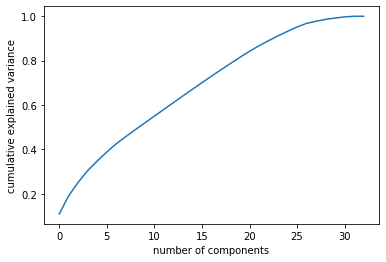

In [140]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [145]:
X_new.shape

(260601, 33)

In [146]:
pca = PCA(26) # remove 7  components

In [147]:
X_new = pca.fit_transform(X_new)

In [148]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean score = {v.mean()}')

[0.73112078 0.73135102 0.73115754]
mean score = 0.7312097798676533


Lets include categorical data as well

In [150]:
cols = X.columns.tolist()
rem_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
cols = [i for i in cols if i not in rem_cols]
X_new = X[cols]

scaler = StandardScaler()

X_new = scaler.fit_transform(X_new)
pca = PCA()
pca.fit(X_new)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

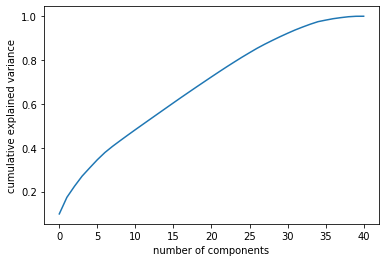

In [151]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [152]:
pca = PCA(26) # remove 7  components
X_new = pca.fit_transform(X_new)
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
v = cross_val_score(estimator=model,X = X_new, y=y, scoring=scorer, cv=3,n_jobs=-1)
print(v)
print(f'mean score = {v.mean()}')

[0.7283925  0.73068334 0.72938468]
mean score = 0.7294868388590817


### cat boost

In [34]:
from catboost import CatBoostClassifier

In [36]:
cat_cols = df.columns[df.dtypes == 'object']

In [44]:
model = CatBoostClassifier(iterations=100,)
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, fit_params={'cat_features':cat_cols}
                , cv=3,n_jobs=-1)

array([0.74422112, 0.74503845, 0.74507569])

In [46]:
cat_preds = cross_val_predict(estimator=model,X = X, y=y, cv=3,fit_params={'cat_features':cat_cols}
                                ,n_jobs=-1,method='predict_proba')

In [47]:
rf_preds = train_preds

In [54]:
from sklearn.neural_network import MLPClassifier

In [55]:
blender = MLPClassifier(hidden_layer_sizes=(10,10))

In [56]:
rf_preds.shape, cat_preds.shape

((260601, 3), (260601, 3))

In [57]:
cross_val_score(blender,X=np.hstack([cat_preds, rf_preds])
                ,y=y,cv=3,scoring=scorer)

array([0.755894  , 0.75485795, 0.75575894])

### log as blender

In [20]:
from sklearn.model_selection import cross_val_predict

In [24]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
train_preds = cross_val_predict(estimator=model,X = X, y=y, cv=3,n_jobs=-1,method='predict_proba')

In [25]:
train_preds.shape

(260601, 3)

In [32]:
blender = LogisticRegression()

In [33]:
cross_val_score(blender,X=train_preds,y=y,cv=3,scoring=scorer)

array([0.73716443, 0.7403762 , 0.73927359])

#### remove corr features 

In [95]:
corr_features = ['height_percentage', 'has_secondary_use_agriculture',
                'geo_level_1_id_fq','geo_level_2_id_fq','geo_level_1_id_tq',
                'geo_level_2_id_tq']

n_f = [i for i in X.columns if i not in corr_features]

In [96]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X[n_f], y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75567528, 0.75611272, 0.75679503])

In [98]:
np.array([0.75567528, 0.75611272, 0.75679503]).mean()

0.7561943433333332

### address overfit

In [52]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1).mean()

0.7539341831196383

In [60]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3,bootstrap=True,
                             n_jobs=-1)
cross_val_score(estimator=model,X=X, y=y, scoring=scorer, cv=3,n_jobs=-1).mean()

0.7564053903644762

### Error analysis

### RF including only freq encoding

In [109]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [110]:
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74058341, 0.74092877, 0.74035572])

In [118]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

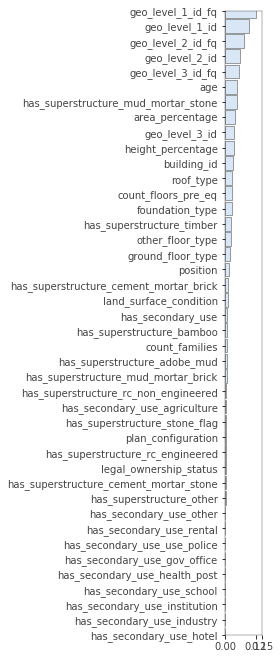

In [119]:
imp = importances(model, X, y) # permutation
viz = plot_importances(imp)

In [128]:
cross_val_score(estimator=model,X = X[top20], y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74113598, 0.74030713, 0.74035572])

### RF including count12 and freq encoding

In [83]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [91]:
cross_val_score(estimator=model,X = X[top20], y=y , scoring=scorer, cv=3,n_jobs=-1)

array([0.74114749, 0.74011143, 0.74009095])

In [102]:
top20.remove('geo_level_3_id_fq')
top20.remove('count_floors_pre_eq')
top20.remove('count12')


In [103]:
# after removing the correlated features
cross_val_score(estimator=model,X = X[top20], y=y , scoring=scorer, cv=3,n_jobs=-1)

array([0.7371299 , 0.73651978, 0.73680999])

In [86]:
from rfpimp import *

In [87]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

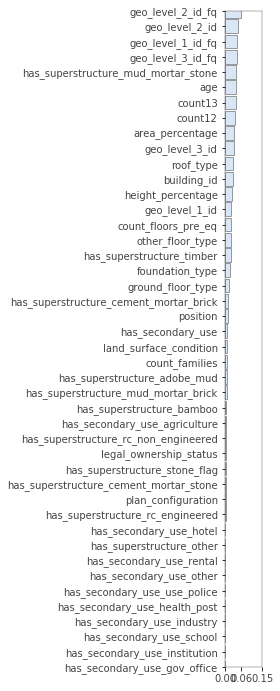

In [88]:
imp = importances(model, X, y) # permutation
viz = plot_importances(imp)

In [90]:
top20 = imp.iloc[:20].index.tolist()

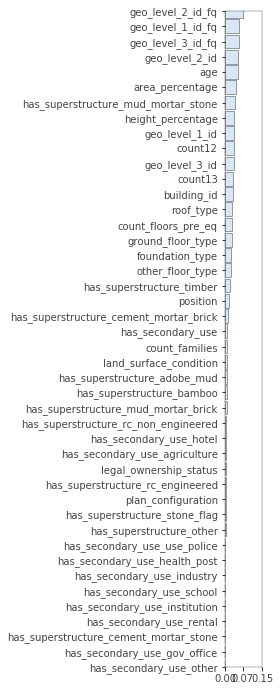

In [81]:
# Pretty much useless

In [88]:
cross_val_score(estimator=estimator,X = X_train[['count_floors_pre_eq','age']], y=y_train, scoring=scorer, cv=3)

array([0.56831054, 0.56859833, 0.56833017])

In [13]:
estimator = RandomForestClassifier(n_estimators=50,min_samples_leaf=1, n_jobs=-1)

In [12]:
cross_val_score(estimator=estimator,X=X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.71525763, 0.71781323, 0.71927704])

In [16]:
np.mean(np.array([0.71525763, 0.71781323, 0.71927704]))

0.7174493000000001

`estimator = RandomForestClassifier(n_estimators=10,min_samples_leaf=1)`  array([0.69160105, 0.69367316, 0.69515916])

`estimator = RandomForestClassifier(n_estimators=50,min_samples_leaf=1, n_jobs=-1)`  array([0.71525763, 0.71781323, 0.71927704])

` RandomForestClassifier(n_estimators=30,min_samples_leaf=1) ` [0.71034213, 0.71319703, 0.71529385] 

` random on one-hot encoding `
array([0.65804439, 0.65726159, 0.6648017 ])

In [109]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)

In [110]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

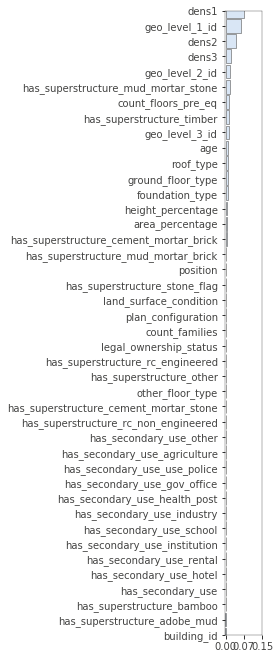

In [113]:
imp = importances(model, X_test, y_test) # permutation
viz = plot_importances(imp)

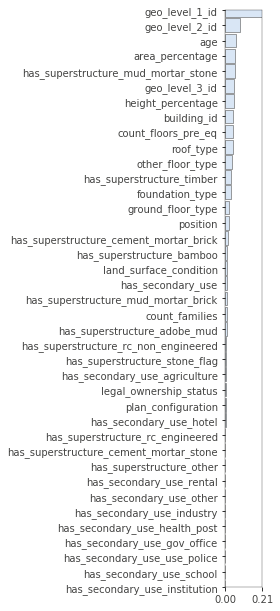

In [26]:
imp = importances(model, X_train, y_train) # permutation
viz = plot_importances(imp)

In [116]:
top20_features = imp.index[:20]

In [117]:
# use only top 10 features

In [119]:
cross_val_score(estimator=model,X = pd.concat([X_train, X_test])[top20_features], y=pd.concat([y_train, y_test]), scoring=scorer, cv=3,n_jobs=-1)

array([0.74003085, 0.74097481, 0.73847925])

### best score

frequency encoding of the geo features

In [134]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [135]:
cross_val_score(estimator=model,X = pd.concat([X_train, X_test])[top20_features], y=pd.concat([y_train, y_test]), scoring=scorer, cv=3,n_jobs=-1)

array([0.74426716, 0.74419809, 0.74108099])

In [133]:
np.array([0.74245982, 0.74248285, 0.7376734 ]).mean()

0.7408720233333334

In [54]:
# <70 for top 10 features
# 72.2 for top 20 features
# 72.2 for top 30 features


In [55]:
# are there any better ways to represent features.

In [56]:
imp.index[:10]

Index(['geo_level_1_id', 'geo_level_2_id',
       'has_superstructure_mud_mortar_stone', 'count_floors_pre_eq',
       'roof_type', 'height_percentage', 'has_superstructure_timber',
       'geo_level_3_id', 'other_floor_type', 'age'],
      dtype='object', name='Feature')

## Error Analysis

## Data Difference

In [535]:
X['label'] = 0
true_test['label'] =1 

In [536]:
X.shape, true_test.shape

((260601, 46), (86868, 46))

In [537]:
comb = pd.concat([X,true_test],axis=0)

In [544]:
model = RandomForestClassifier()

In [545]:
features = [i for i in X.columns if i!='label']

In [546]:
model.fit(comb[features], comb['label'])

/data/nithish/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [547]:
model.score(comb[features], comb['label'])

0.8356803052934219

In [548]:
imp = importances(model, comb[features], comb['label'])

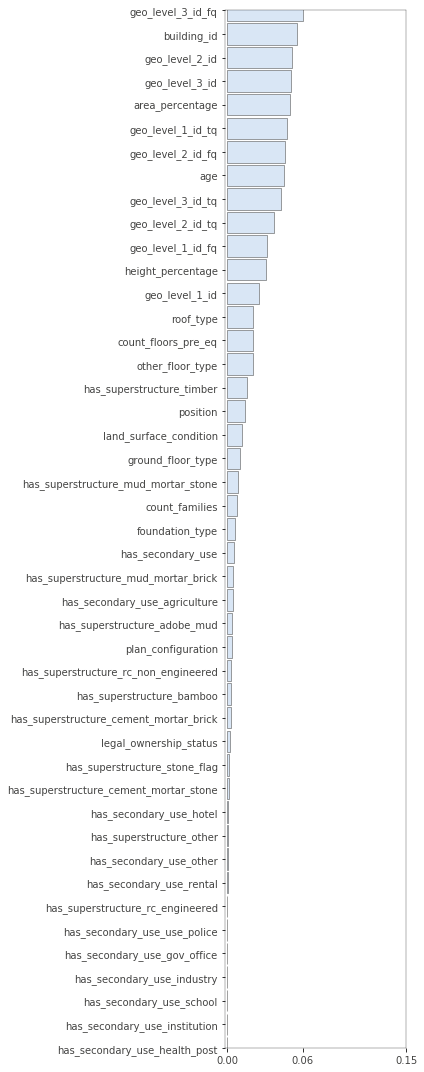

In [550]:
_, ax = plt.subplots(1,1, figsize=(6,15))
viz = plot_importances(imp,ax=ax)

## Visuals

In [47]:
frame = pd.concat([geo,pd.DataFrame(y)],axis=1)

In [54]:
import matplotlib.pyplot as plt

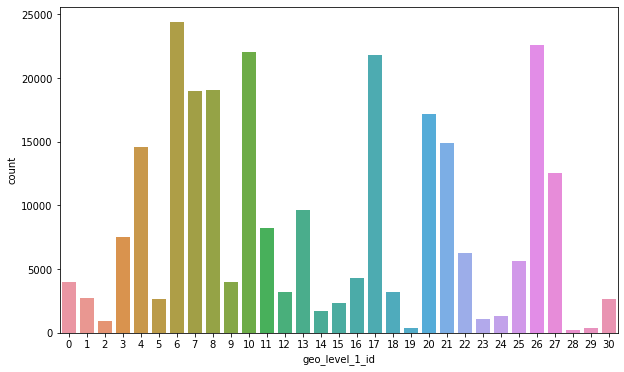

In [77]:
plt.figure(figsize=(10,6))
_ = sns.countplot(x='geo_level_1_id', data=frame)

In [87]:
x = true_test.groupby('geo_level_3_id',as_index=False)['building_id'].count()
x.sort_values('building_id',ascending=False,inplace=True)
x = x.iloc[:50]


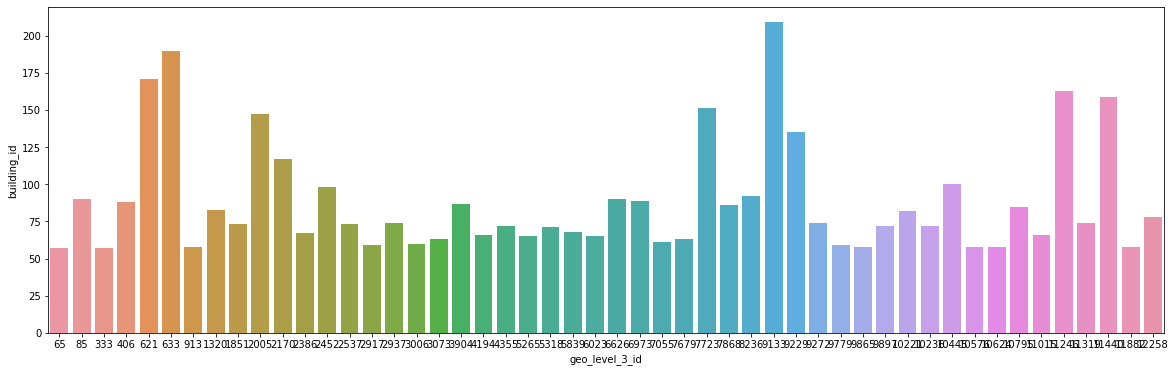

In [88]:
plt.figure(figsize=(20,6))
_ = sns.barplot(x='geo_level_3_id', y='building_id', data=x)

In [89]:
x = X.groupby('geo_level_3_id',as_index=False)['building_id'].count()
x.sort_values('building_id',ascending=False,inplace=True)

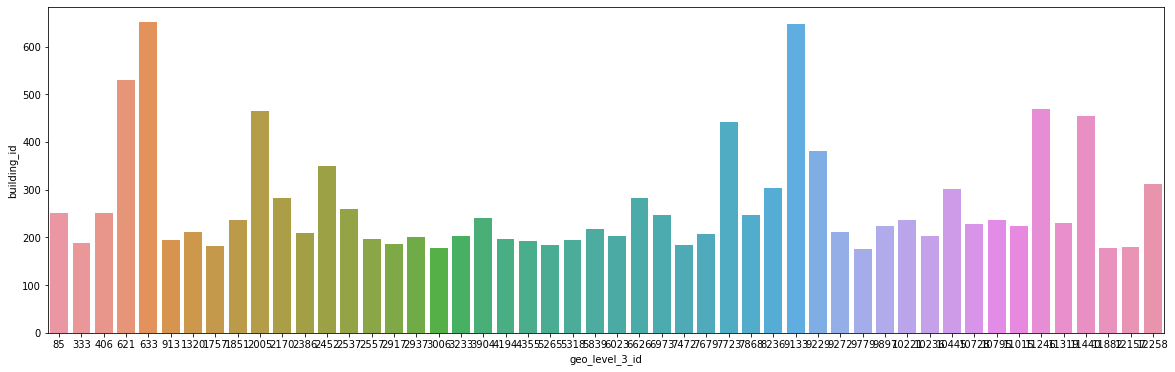

In [90]:
x = x.iloc[:50]


plt.figure(figsize=(20,6))
_ = sns.barplot(x='geo_level_3_id', y='building_id', data=x)

In [91]:
# all the 3 geo locations seem to be consistent within in train and test sets

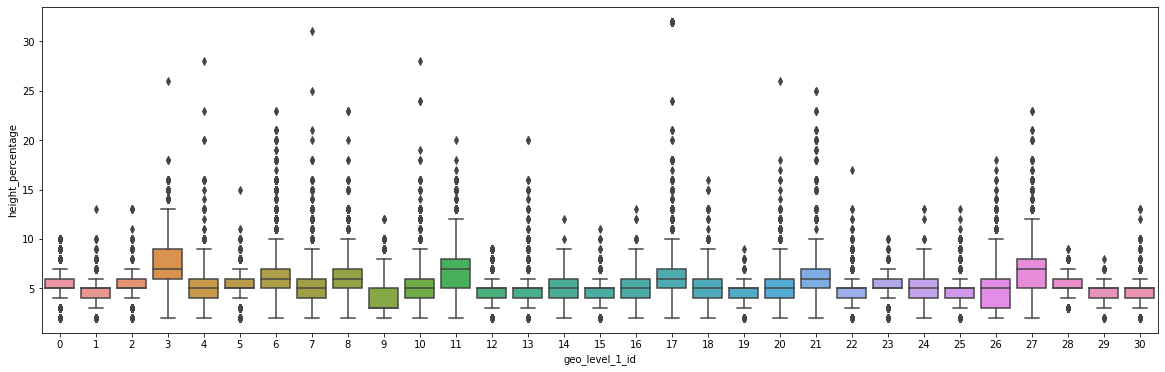

In [174]:
plt.figure(figsize=(20,6))
sns.boxplot(x='geo_level_1_id', y='height_percentage', data=X)

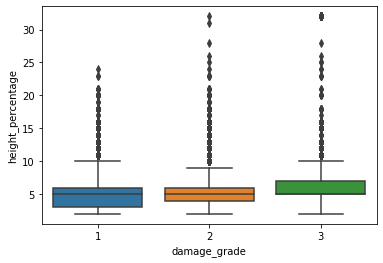

In [205]:
sns.boxplot(x=y,y=X.height_percentage)

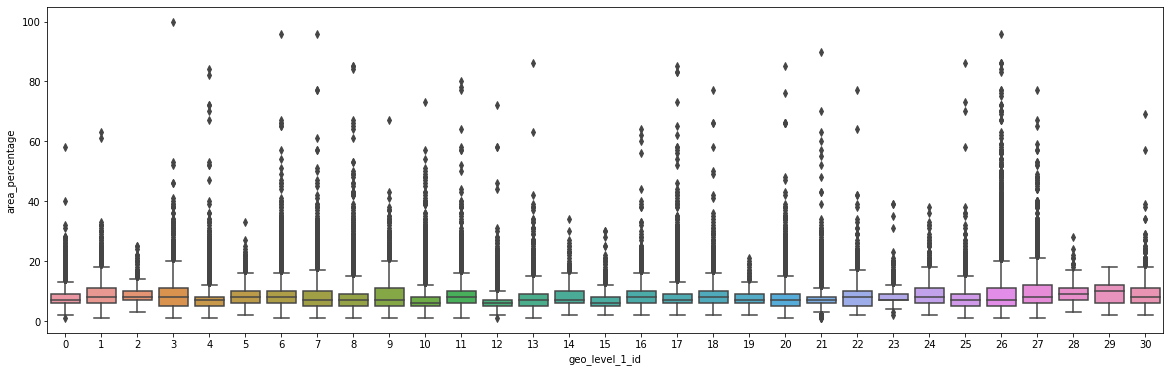

In [177]:
plt.figure(figsize=(20,6))
sns.boxplot(x='geo_level_1_id', y='area_percentage', data=X)

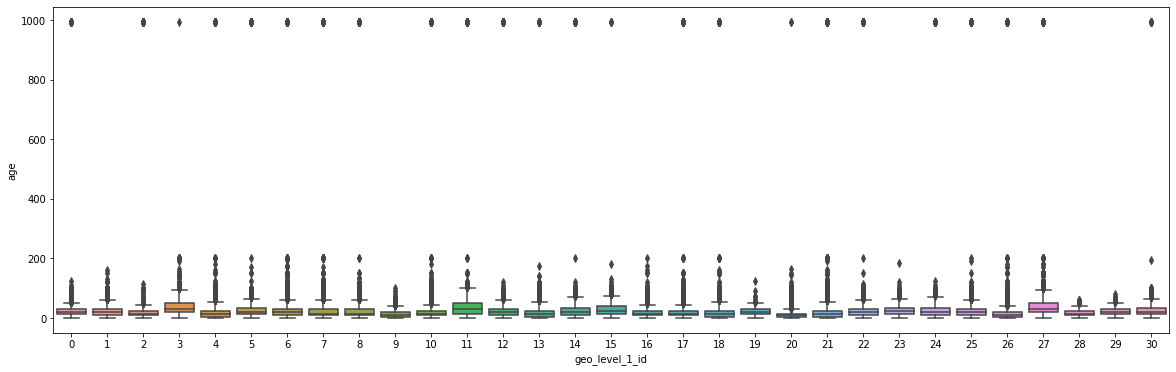

In [178]:
plt.figure(figsize=(20,6))
sns.boxplot(x='geo_level_1_id', y='age', data=X)

In [180]:
sum(X.age>250)

1390

In [181]:
sum(X.area_percentage>70)

43

In [201]:
# sns.barplot(x='geo_level_1_id',y='building_id',hue='land_surface_condition',data=X)
x = X.groupby(['geo_level_1_id', 'land_surface_condition'], as_index=False).agg({'building_id':'nunique'})

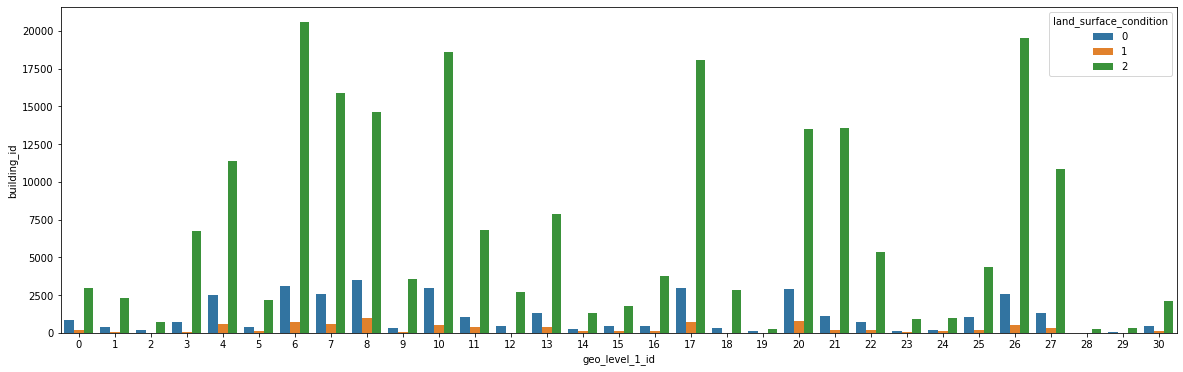

In [203]:
plt.figure(figsize=(20,6))
sns.barplot(x='geo_level_1_id', y='building_id', hue='land_surface_condition', data=x)

In [210]:
all(train_target.index == X.index)

True

In [ ]:
X.h

In [213]:
comb = pd.merge(X,train_target , on='building_id')
print(X.shape, y.shape, comb.shape)

(260601, 45) (260601,) (260601, 46)


In [220]:
comb['disc'] = comb['ground_floor_type'].astype(str) + comb['other_floor_type'].astype(str)

In [227]:
x = comb.groupby(['disc','damage_grade'], as_index=False)['building_id'].count()

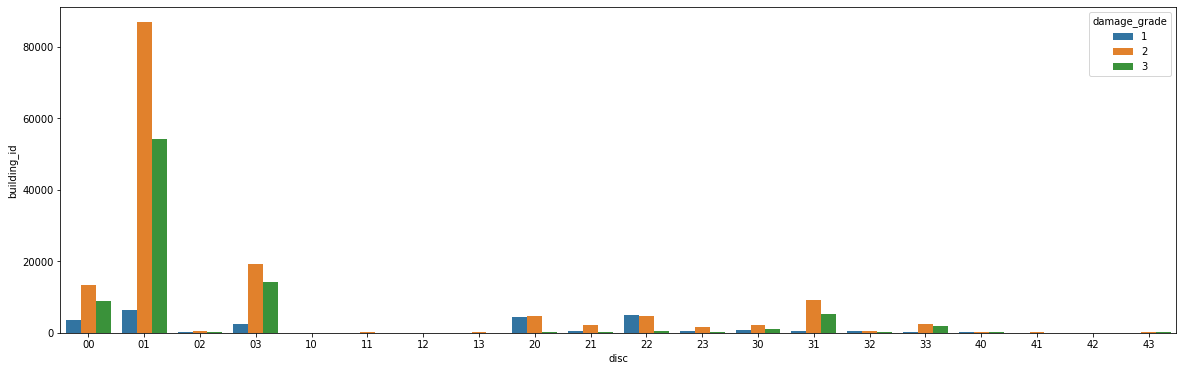

In [231]:
plt.figure(figsize=(20,6))

sns.barplot(x='disc', hue='damage_grade', y = 'building_id' , data=x)

In [232]:
from sklearn.feature_selection import chi2

In [235]:
chi2(comb[['disc']], comb.damage_grade)

(array([183291.09990433]), array([0.]))

From chi2 test this feature seems promising

In [94]:
col = X.geo_level_1_id

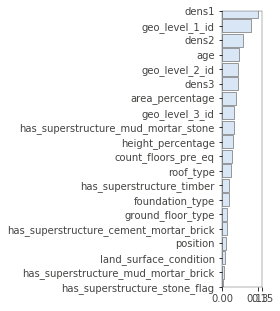

In [397]:
imp = importances(model, X_train[top20_features], y_train) # permutation
viz = plot_importances(imp)

In [398]:
corr_features = ['count_floors_pre_eq','dens3']

In [399]:
top18 = [i for i in top20_features if i not in corr_features]

In [400]:
len(top18)

18

In [314]:
##ilocdd the geo2 and geo 3 locations in geo1 as a feature

In [402]:
cross_val_score(estimator=model,X = X[top18], y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74084818, 0.7402726 , 0.7402406 ])

In [413]:
X, true_test = geo23_in_geo1(X_train, X_test)

/data/nithish/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/data/nithish/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [417]:
 pd.concat([X_train, X_test],axis=0).shape

(260601, 44)

In [ ]:
model = 

In [424]:
cross_val_score(estimator=model,X =, 
                y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.54382511, 0.54534466, 0.54531745])

### Check univariate dists

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'land_surface_condition',

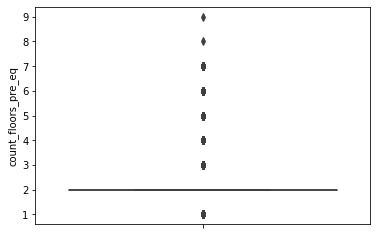

In [354]:
_ = sns.boxplot(y='count_floors_pre_eq', data=X)

(array([4.04410e+04, 1.56623e+05, 5.56170e+04, 5.42400e+03, 0.00000e+00,
        2.24600e+03, 2.09000e+02, 3.90000e+01, 1.00000e+00, 1.00000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

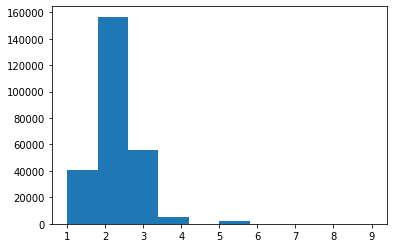

In [355]:
plt.hist(X['count_floors_pre_eq'])

(array([2.57113e+05, 1.99200e+03, 1.06000e+02, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.39000e+03]),
 array([  0. ,  99.5, 199. , 298.5, 398. , 497.5, 597. , 696.5, 796. ,
        895.5, 995. ]),
 <a list of 10 Patch objects>)

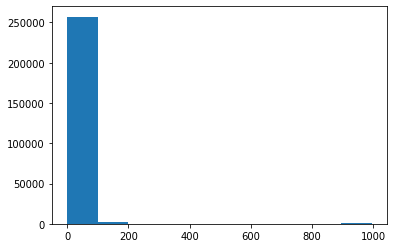

In [360]:
plt.hist(X['age'])

In [362]:
sum(X.age>200)  # age needs to be handled

1390

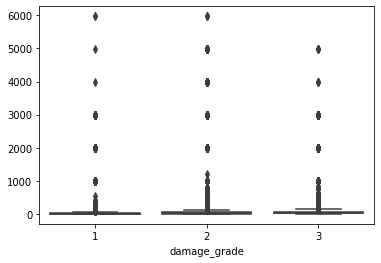

In [369]:
sns.boxplot(x=y, y = X.age*X.count_floors_pre_eq)

In [377]:
X.iloc[:10,5:]

,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,...,other_floor_type,position,plan_configuration,legal_ownership_status,geo_level_1_id_fq,geo_level_2_id_fq,geo_level_3_id_fq,geo_level_1_id_tq,geo_level_2_id_tq,geo_level_3_id_tq
0,30,6,5,1,1,0,0,0,0,0,...,1,3,2,2,24381,270,37,2.161724,2.740741,2.837838
1,10,8,7,0,1,0,0,0,0,0,...,1,2,2,2,19080,199,16,2.485273,2.487437,2.062500
2,10,5,5,0,1,0,0,0,0,0,...,3,3,2,2,14889,1760,136,2.563369,2.518750,2.580882
3,10,6,5,0,1,0,0,0,0,1,...,3,2,2,2,6252,205,31,2.000960,2.107317,2.096774
4,30,8,9,1,0,0,0,0,0,0,...,3,2,2,2,8220,1038,122,2.337713,2.348748,2.368852
5,10,9,5,0,1,0,0,0,0,0,...,1,2,2,2,19080,419,38,2.485273,2.546539,2.368421
6,25,3,4,0,1,0,0,0,0,0,...,1,2,2,2,3958,138,9,2.026023,2.137681,2.555556
7,0,8,6,0,0,0,0,0,1,1,...,3,2,9,2,17216,251,20,1.926464,1.282869,1.100000
8,15,8,6,0,1,0,0,0,0,1,...,1,2,2,2,4011,295,37,2.065320,2.105085,2.189189
9,0,13,4,0,0,0,0,0,1,0,...,0,2,2,2,22615,1053,107,1.730887,1.545109,1.551402


## XGBoost 

In [67]:
X.shape, y.shape

((260601, 48), (260601,))

In [ ]:
X.geo_comb = X.geo_comb.astype(int)

In [68]:
from xgboost import XGBClassifier

In [80]:
cross_val_score(estimator=xgb,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.75010361, 0.74892941, 0.74966903])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)
def test1(model):
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    print('f1score is = ', f1_score(preds,y_test, average='micro'))

In [120]:
y_train = y_train-1
y_test = y_test - 1

In [87]:
test1(xgb)

f1score is =  0.7505228218952054


In [88]:
import xgboost as xgb

In [121]:
dtrain = xgb.DMatrix(X_train, label=y_train.values)

In [122]:
dtest = xgb.DMatrix(X_test, label = y_test.values)

In [123]:
params = dict(max_depth=20, learning_rate=0.1, 
              n_estimators=60, verbosity=1,
              objective='multi:softmax', booster='gbtree', 
              tree_method='auto', n_jobs=12, gamma=0, min_child_weight=1, 
              max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1,
              colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
              base_score=0.5, random_state=0, missing=None, num_parallel_tree=1, importance_type='gain')


In [124]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [125]:
def f1_xgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    return f1_score(y_true, y_pred, average='micro')

In [126]:
params['num_class'] = 3

In [127]:
num_round = 10
bst = xgb.train(params, dtrain, num_round, evallist)

[0]	eval-merror:0.269392	train-merror:0.153554
[1]	eval-merror:0.262735	train-merror:0.146297
[2]	eval-merror:0.25932	train-merror:0.14304
[3]	eval-merror:0.258322	train-merror:0.140085
[4]	eval-merror:0.257439	train-merror:0.136886
[5]	eval-merror:0.256327	train-merror:0.133989
[6]	eval-merror:0.255789	train-merror:0.131797
[7]	eval-merror:0.255655	train-merror:0.12925
[8]	eval-merror:0.255252	train-merror:0.126137
[9]	eval-merror:0.254005	train-merror:0.123681


In [136]:
bst.get_fscore()

{'geo_level_3_id_tq': 471,
 'age': 22731,
 'foundation_type': 2284,
 'geo_level_3_id': 21819,
 'area_percentage': 26952,
 'has_superstructure_rc_non_engineered': 976,
 'building_id': 64612,
 'has_secondary_use': 1974,
 'land_surface_condition': 3661,
 'height_percentage': 12662,
 'count_families': 4566,
 'legal_ownership_status': 1440,
 'roof_type': 3734,
 'has_superstructure_cement_mortar_brick': 1147,
 'position': 5530,
 'has_superstructure_bamboo': 1213,
 'geo_level_3_id_fq': 16140,
 'geo_level_2_id': 13724,
 'has_secondary_use_hotel': 799,
 'geo_level_2_id_fq': 10257,
 'has_superstructure_cement_mortar_stone': 640,
 'has_superstructure_timber': 2430,
 'geo_level_2_id_tq': 697,
 'geo_comb': 14663,
 'geo_level_1_id': 5144,
 'ground_floor_type': 2767,
 'has_superstructure_mud_mortar_stone': 1581,
 'geo_level_1_id_fq': 2856,
 'count_floors_pre_eq': 5196,
 'has_superstructure_mud_mortar_brick': 1024,
 'other_floor_type': 3147,
 'has_superstructure_other': 562,
 'plan_configuration': 173

## combine Xgboost and Randomforestclass

In [27]:
from xgboost import XGBClassifier

In [71]:
model = XGBxgb = XGBClassifier(**params)Classifier(n_estimators=30, max_depth=7, n_jobs=-1)
# cross_val_score(estimator=model,X=X, y=y, scoring=scorer, cv=3,n_jobs=-1).mean()

0.752610326828627

In [72]:
model = XGBClassifier(n_estimators=30, max_depth=10, n_jobs=-1)
cross_val_score(estimator=model,X=X, y=y, scoring=scorer, cv=3,n_jobs=-1).mean()

0.7556647990050694

In [21]:
X_train, X_test, y_train, y_test = t_split(X, y, test_size=0.2, random_state=999)
def test1(model):
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    print('f1score is = ', f1_score(preds,y_test, average='micro'))

In [23]:
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

In [22]:
test1(gradb)

f1score is =  0.741850693578404


In [35]:
xgb = XGBClassifier(n_estimators=200, max_depth=10, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)
gradb = GradientBoostingClassifier(n_estimators=200,min_samples_leaf=3)

In [36]:
voting = VotingClassifier(estimators=[('xg',xgb),
                                      ('rf',rf),
                                      ('gb',gradb)],  voting='hard',n_jobs=-1)

In [38]:
test1(voting)

f1score is =  0.7567774985130752


In [39]:
X.shape

(260601, 45)

In [45]:
preds = voting.predict(true_test)

In [46]:
give_sub_file(preds, true_test.building_id.tolist(), path='../output/votingpreds.csv')

Index(['building_id', 'damage_grade'], dtype='object')
(86868, 2)


In [47]:
train_preds = voting.predict(X_train)

In [49]:
f1_score(y_train, train_preds, average='micro')

0.8055353031465847

In [ ]:
model = XGBClassifier(n_estimators=30, max_depth=15, n_jobs=-1)
cross_val_score(estimator=model,X=X, y=y, scoring=scorer, cv=3,n_jobs=-1).mean()

In [75]:
model = XGBClassifier(n_estimators=200, max_depth=10, n_jobs=12)
cross_val_score(estimator=model,X=X, y=y, scoring=scorer, cv=3,n_jobs=-1).mean()

0.7572764613892282

In [13]:
from sklearn.pipeline import Pipeline

In [76]:
model = XGBClassifier(n_estimators=200, max_depth=10, n_jobs=12)


In [77]:
model.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=12,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [78]:
train_preds = model.predict(X)
print(classification_report(y, train_preds ))

              precision    recall  f1-score   support

           1       0.85      0.72      0.78     25124
           2       0.81      0.89      0.85    148259
           3       0.83      0.72      0.77     87218

    accuracy                           0.82    260601
   macro avg       0.83      0.78      0.80    260601
weighted avg       0.82      0.82      0.82    260601



In [79]:
# xgboost f1 score
f1_score(train_preds, y, average='micro')

0.8192639322182187

RANDOM FOREST 

                precision    recall  f1-score   support

           1       0.89      0.73      0.80     25124
           2       0.85      0.93      0.89    148259
           3       0.89      0.78      0.83     87218

    accuracy                           0.86    260601
   macro avg       0.88      0.82      0.84    260601
weighted avg       0.87      0.86      0.86    260601

In [81]:
preds = model.predict(true_test)
give_sub_file(preds, true_test.building_id.tolist(), path='../output/tefexgboostn200md10.csv')

Index(['building_id', 'damage_grade'], dtype='object')
(86868, 2)


In [86]:
pd.Series(preds).value_counts(normalize=True)

2    0.635205
3    0.286607
1    0.078188
dtype: float64

In [87]:
pd.Series(train_preds).value_counts(normalize=True)

2    0.626728
3    0.291139
1    0.082133
dtype: float64